# Loading modules

In [82]:
import pandas as pd
import numpy as np
import json
import collections
import re
from IPython.display import clear_output
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, confusion_matrix, recall_score, auc, roc_curve
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, plot_confusion_matrix

from spacy.lang.en import English
import spacy

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
import nltk
nltk.download('punkt')
from string import punctuation
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Allison\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data loading

In [2]:
data = []
with open("reviews.json", "r") as json_file:
    for line in json_file:
        data.append(json.loads(line))

In [3]:
df = pd.DataFrame(data)

In [4]:
df = df.drop(labels = [col for col in df.columns if col not in ['overall', 'reviewText', 'summary']], axis=1)

In [5]:
df = df.dropna(axis=0, subset=['reviewText'])
df = df.dropna(axis=0, subset=['summary'])
df = df.dropna(axis=0, subset=['overall'])

In [6]:
df['overall'] = df['overall'].astype('int32')
df['overall'] = df['overall'].replace(1, 0)
df['overall'] = df['overall'].replace(2, 1)
df['overall'] = df['overall'].replace(3, 2)
df['overall'] = df['overall'].replace(4, 3)
df['overall'] = df['overall'].replace(5, 4)
df.head()

,overall,reviewText,summary
0,3,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...
1,0,It sucks barely picks up anything definitely n...,sucks
2,0,"Well to write a short one, it blew 2 fuses of ...",Defective
3,2,I have absolutely no memory of buying this but...,Looks cool! Probably works
4,4,it ok it does it job,Five Stars


In [7]:
print(df['overall'].value_counts())

4    723610
3    145621
2     59558
0     41928
1     28792
Name: overall, dtype: int64


In [8]:
reviewText = df['reviewText'].to_numpy()
summary = df['summary'].to_numpy()
overall = df['overall'].to_numpy()

# Text preprocessing

In [43]:
exclude=['tagger', 'ner', 'attribute_ruler', 'lemmatizer', 'parser']
nlp = spacy.load('en_core_web_md', disable=exclude)

for pipe in nlp.pipeline:
    print(pipe[0])

('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x00000270FB7EC810>)


In [10]:
def get_spacy_doc_vector(text):
    text_tokens = [token for token in nlp(text)]
    clean_tokens = [token for token in text_tokens if token.text not in punctuation]
    not_null_tokens = [token.text for token in clean_tokens if any(token.vector)]
    return spacy.tokens.doc.Doc(nlp.vocab, words=not_null_tokens, spaces=None).vector
    
text = "Nick likes to play asdtyucvbn football, however he is not too fond of tennis dfsauifyadfsaf6stftsf."
print(get_spacy_doc_vector(text))

[ 1.63474321e-01  2.35199228e-01 -1.08499303e-01 -1.63953006e-01
  5.81135377e-02 -6.21292330e-02  1.69210017e-01 -1.53274462e-01
  6.78331824e-04  2.35654449e+00 -1.84112921e-01  5.80796190e-02
  8.83183107e-02  5.68091050e-02 -9.79595855e-02 -3.18630934e-02
 -5.38004637e-02  6.53856337e-01 -9.67848450e-02  8.93674567e-02
 -8.31639245e-02 -1.78414524e-01 -1.34311810e-01 -1.31124675e-01
  4.75685410e-02  1.86282888e-01 -1.45664871e-01  9.48518608e-03
 -5.02543077e-02 -2.48364713e-02 -5.46054654e-02  6.77761585e-02
 -3.82177718e-02 -1.25679187e-02  7.74515001e-03 -5.60023859e-02
  1.18696783e-02 -7.92523101e-03 -3.62585373e-02 -3.43072377e-02
  4.83157188e-02  1.97839156e-01  1.59617007e-01  2.39417721e-02
  3.50391865e-03  5.52188698e-03 -1.35563463e-01  9.72715467e-02
 -1.57500267e-01  1.07099533e-01 -1.70880467e-01  6.68548048e-02
  6.63619190e-02 -9.17673931e-02  8.06933790e-02 -3.64931561e-02
 -2.82289274e-02 -3.35873105e-02  8.07441548e-02 -4.37116958e-02
  3.94755602e-03  1.10878

In [11]:
for i in range(len(reviewText)):
    reviewText[i] = get_spacy_doc_vector(reviewText[i])
    summary[i] = get_spacy_doc_vector(summary[i])
    if i % 100000 == 0:
        print(i)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000


In [12]:
df.head()

,overall,reviewText,summary
0,3,"[-0.009931199, 0.16019917, -0.19412772, -0.018...","[-0.009252692, 0.1573127, -0.16074006, -0.0739..."
1,0,"[-0.21352093, 0.1927869, -0.27589127, -0.03961...","[-0.94507, 0.13348, -0.3, -0.15363, -0.29071, ..."
2,0,"[-0.007160707, 0.1683325, -0.09650622, 0.02659...","[-0.063381, 0.42333, -0.51082, 0.15436, -0.441..."
3,2,"[-0.042970385, 0.19092175, -0.20956193, -0.054...","[0.0013926525, 0.13733649, -0.10146071, -0.140..."
4,4,"[-0.093076885, 0.28408, -0.23881684, -0.183654...","[0.02243275, -0.05039515, -0.033619545, -0.250..."


In [13]:
df.to_pickle('vectors21full.pkl')

In [2]:
df = pd.read_pickle('vectors21full.pkl')
df.head()

,overall,reviewText,summary
0,3,"[-0.009931199, 0.16019917, -0.19412772, -0.018...","[-0.009252692, 0.1573127, -0.16074006, -0.0739..."
1,0,"[-0.21352093, 0.1927869, -0.27589127, -0.03961...","[-0.94507, 0.13348, -0.3, -0.15363, -0.29071, ..."
2,0,"[-0.007160707, 0.1683325, -0.09650622, 0.02659...","[-0.063381, 0.42333, -0.51082, 0.15436, -0.441..."
3,2,"[-0.042970385, 0.19092175, -0.20956193, -0.054...","[0.0013926525, 0.13733649, -0.10146071, -0.140..."
4,4,"[-0.093076885, 0.28408, -0.23881684, -0.183654...","[0.02243275, -0.05039515, -0.033619545, -0.250..."


In [37]:
def in_two_best_predict(best_2, y):
    correct = 0
    for i in range(len(y)):
        if y[i] in best_2[i]:
            correct += 1
    return correct / len(y)

In [4]:
reviewText = df['reviewText'].to_numpy()
reviewText = np.concatenate(reviewText)
summary = df['summary'].to_numpy()
summary = np.concatenate(summary)
overall = df['overall'].to_numpy()

In [5]:
reviewText.shape

(299852700,)

In [6]:
reviewText = reviewText.reshape((999509, 300))
summary = summary.reshape((999509, 300))

In [7]:
overall.shape

(999509,)

In [8]:
X = np.hstack((reviewText, summary))

In [9]:
X.shape

(999509, 600)

In [10]:
Y = df['overall'].to_numpy()

In [11]:
Y.shape

(999509,)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 21)

# Model selection

In [14]:
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42, verbose=True)
classifier.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [15]:
pickle.dump(classifier, open('model21.pkl', 'wb'))

In [16]:
classifier.score(X_test, Y_test)

0.8313296888881774

In [41]:
predicted = classifier.predict_proba(X_test)
best_2 = np.argsort(predicted, axis=1)[:, -2:]

In [42]:
print(in_two_best_predict(best_2, Y_test))

0.9278647980214345


In [54]:
classifier2 = LogisticRegression(random_state=42, C=10, max_iter=1000, verbose=True)

In [55]:
classifier2.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.9min finished


LogisticRegression(C=10, max_iter=1000, random_state=42, verbose=True)

In [56]:
classifier2.score(X_test, Y_test)

0.8094270003761835

In [60]:
predicted = classifier2.predict_proba(X_test)
best_2 = np.argsort(predicted, axis=1)[:, -2:]

In [61]:
print(in_two_best_predict(best_2, Y_test))

0.9237828060093326


# Results

In [73]:
pd.Series(Y_test).value_counts()

4    181051
3     36283
2     14888
0     10421
1      7235
dtype: int64

In [74]:
predict = classifier.predict(X_test)

In [75]:
matrix = confusion_matrix(predict, Y_test)
print(matrix)

[[  4567    459    146     25     40]
 [   117   2227     84      7      6]
 [   111    217   5770    299     59]
 [    60     75    460  14637    416]
 [  5566   4257   8428  21315 180530]]


In [76]:
# accuracy for each class
matrix.diagonal()/matrix.sum(axis=1)

array([0.87206416, 0.91233101, 0.89374226, 0.9353911 , 0.82023299])

In [80]:
roc_auc_score(Y_test, classifier.predict_proba(X_test), multi_class='ovr')

0.9289048416785783

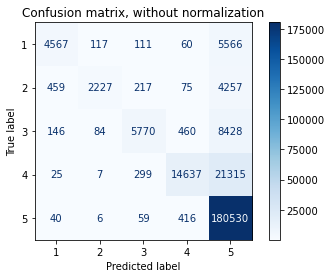

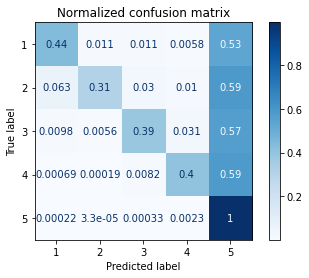

In [85]:
np.set_printoptions(precision=2)

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, Y_test,
                                 display_labels=['1', '2', '3', '4', '5'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()